In [1]:
# !pip install "tensorflow<2.11" opencv-python matplotlib
# !pip list # Uncomment first part to check dependencies/versions
# !python -m pip install --upgrade pip

In [2]:
import tensorflow as tf
import os

In [3]:
import cv2
import imghdr
from matplotlib import pyplot as plt
data_dir = 'data'
print(os.listdir(data_dir))

['bad', 'good']


In [4]:
import numpy as np
from matplotlib import pyplot as plt

In [5]:
data = tf.keras.utils.image_dataset_from_directory('data') # Here, we load the data from the directory

Found 4626 files belonging to 2 classes.


The code below creates a NumPy iterator from a dataset and retrieves the next batch of data. This is needed to later display images and figure out which class is a bad bean and which one is a good bean. 

In [6]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

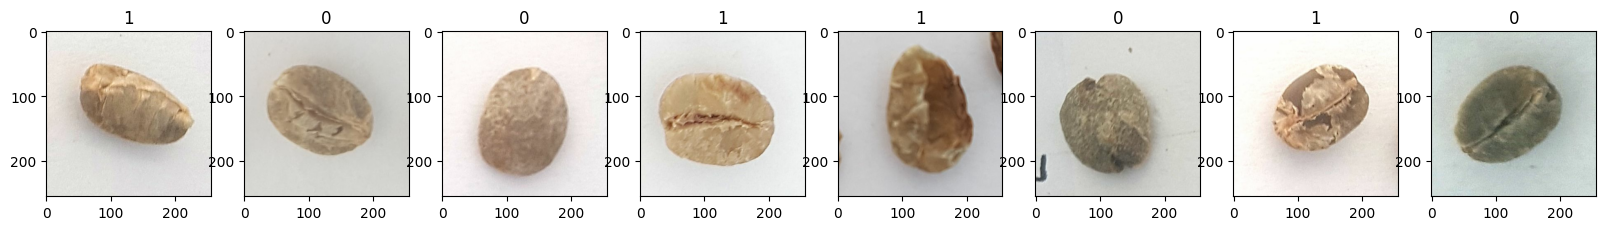

In [7]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20)) # 0 is bad bean
for idx, img in enumerate(batch[0][8:16]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

The code below normalizes the dataset by dividing the feature values by 255, while keeping the labels unchanged. This normalization step is needed so that data is scaled to the range [0, 1] to improve model performance.

In [8]:
def normalize(x, y):
    return x / 255, y

data = data.map(normalize)


In [9]:
import math

total_size = len(data)
train_size = math.floor(total_size * 0.7)
val_size = math.floor(total_size * 0.2)
test_size = total_size - train_size - val_size


In [10]:
train_size

101

The code below defines a train, validation, and test dataset.

In [11]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

MODEL.

This code builds a Convolutional Neural Network (CNN) using a sequential model. It consists of three convolutional layers with ReLU activation, each followed by max pooling layers to reduce spatial dimensions. After flattening the feature maps, it includes a dense layer with 256 units and ReLU activation, and a final output layer with a single unit and sigmoid activation for binary classification. The input shape is specified as 256x256 pixels with 3 color channels (RGB).

In [13]:
model = Sequential()

In [14]:
model.add(Conv2D(32, (2,2), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, (2,2), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (2,2), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [15]:
from tensorflow.keras.optimizers import Adam
learning_rate = 0.0005  
# This learning rate has significantly improved the results, signifying that this model benefits from 
# a slow learning rate

# An instance of the Adam optimizer with our learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        8224      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0

In [17]:
logdir='logs'


This code initializes a TensorBoard callback in TensorFlow/Keras for logging model metrics and visualizations during training.

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [19]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
101/101 [==============================] - 27s 129ms/step - loss: 0.6199 - accuracy: 0.6584 - val_loss: 0.4898 - val_accuracy: 0.7737
Epoch 2/20
101/101 [==============================] - 12s 117ms/step - loss: 0.4957 - accuracy: 0.7537 - val_loss: 0.4518 - val_accuracy: 0.7953
Epoch 3/20
101/101 [==============================] - 12s 117ms/step - loss: 0.4705 - accuracy: 0.7692 - val_loss: 0.4337 - val_accuracy: 0.8028
Epoch 4/20
101/101 [==============================] - 12s 118ms/step - loss: 0.4358 - accuracy: 0.7927 - val_loss: 0.3989 - val_accuracy: 0.8233
Epoch 5/20
101/101 [==============================] - 12s 117ms/step - loss: 0.4136 - accuracy: 0.8063 - val_loss: 0.4182 - val_accuracy: 0.8039
Epoch 6/20
101/101 [==============================] - 12s 117ms/step - loss: 0.3775 - accuracy: 0.8252 - val_loss: 0.3445 - val_accuracy: 0.8524
Epoch 7/20
101/101 [==============================] - 12s 118ms/step - loss: 0.3378 - accuracy: 0.8506 - val_loss: 0.3283 - val_ac

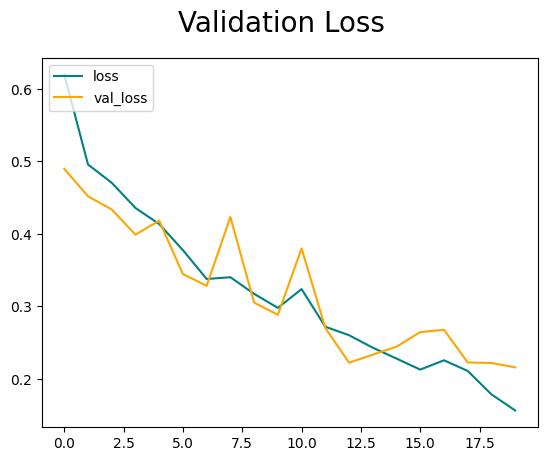

In [20]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Validation Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

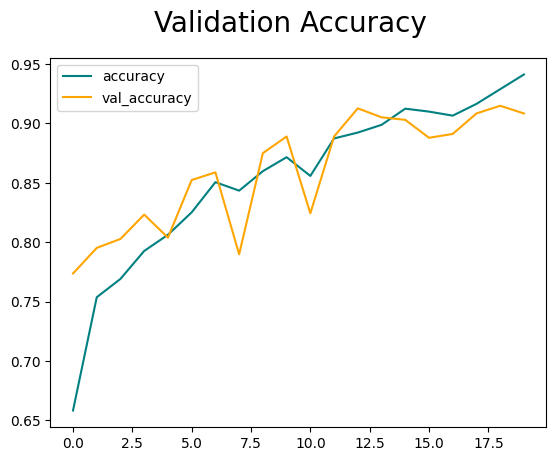

In [21]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Validation Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [22]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())

1/1 [==============================] - 0s 471ms/step
tf.Tensor(0.8995434, shape=(), dtype=float32) tf.Tensor(0.8755556, shape=(), dtype=float32) tf.Tensor(0.8927039, shape=(), dtype=float32)


In [23]:
from tensorflow.keras.models import load_model

In [25]:
model.save(os.path.join('models','CoffeeModel.h5'))